# e2e examples

In this notebook we will show how to generate a lognormal mock, apply and assess quality of reconstruction.
We use pypower; look at https://github.com/cosmodesi/pypower/blob/main/nb/basic_examples.ipynb to understand the pypower API.

In [1]:
import os
import tempfile

import numpy as np

# For mockfactory installation, see https://github.com/cosmodesi/mockfactory
from mockfactory import EulerianLinearMock, LagrangianLinearMock, utils, setup_logging
# For cosmoprimo installation, see https://cosmoprimo.readthedocs.io/en/latest/user/building.html
from cosmoprimo.fiducial import DESI

from pyrecon import MultiGridReconstruction, IterativeFFTReconstruction, PlaneParallelFFTReconstruction
# For pypower installation, see https://pypower.readthedocs.io/en/latest/user/building.html
from pypower import CatalogFFTPower
from pyrecon.metrics import MeshFFTCorrelator, MeshFFTPropagator, CatalogMesh

# Set up logging
setup_logging()

In [2]:
import matplotlib
rc_fonts = {
    "font.family": "serif",
    "font.size": 20,
    'figure.figsize': (5, 3),
    "text.usetex": True,
}
matplotlib.rcParams.update(rc_fonts)
from matplotlib import pyplot as plt

## Lognormal mock in box

### BGS

In [87]:
bias, nbar, nmesh, boxsize, boxcenter, los = 1.5, 3e-4, 256, 2000., 0., 'x' # BGS
z = 0.296
# Load DESI fiducial cosmology
cosmo = DESI()
power = cosmo.get_fourier().pk_interpolator().to_1d(z=z)
f = cosmo.sigma8_z(z=z,of='theta_cb')/cosmo.sigma8_z(z=z,of='delta_cb') # growth rate
print(f)

0.6811794032653128


### LRG

In [3]:
bias, nbar, nmesh, boxsize, boxcenter, los = 2.0, 3.5e-4, 500, 2000., 0., 'x' # LRG
z = 0.780
# Load DESI fiducial cosmology
cosmo = DESI()
power = cosmo.get_fourier().pk_interpolator().to_1d(z=z)
f = cosmo.sigma8_z(z=z,of='theta_cb')/cosmo.sigma8_z(z=z,of='delta_cb') # growth rate
print(f)

0.8340979489032895


### ELG

In [23]:
bias, nbar, nmesh, boxsize, boxcenter, los = 1.2, 5.2e-4, 256, 2000., 0., 'x' # LRG
z = 1.194
# Load DESI fiducial cosmology
cosmo = DESI()
power = cosmo.get_fourier().pk_interpolator().to_1d(z=z)
f = cosmo.sigma8_z(z=z,of='theta_cb')/cosmo.sigma8_z(z=z,of='delta_cb') # growth rate
print(f)

0.9007686447664733


### QSO

In [77]:
bias, nbar, nmesh, boxsize, boxcenter, los = 2.1, 5.7e-4, 256, 2000., 0., 'x' # LRG
z = 1.495
# Load DESI fiducial cosmology
cosmo = DESI()
power = cosmo.get_fourier().pk_interpolator().to_1d(z=z)
f = cosmo.sigma8_z(z=z,of='theta_cb')/cosmo.sigma8_z(z=z,of='delta_cb') # growth rate
print(f)

0.9281307553089333


### Mock generation

In [23]:
mock = LagrangianLinearMock(power, nmesh=nmesh, boxsize=boxsize, boxcenter=boxcenter, seed=42, unitary_amplitude=False)
# This is Lagrangian bias, Eulerian bias - 1
mock.set_real_delta_field(bias=bias-1)
#mock = EulerianLinearMock(power, nmesh=nmesh, boxsize=boxsize, boxcenter=boxcenter, seed=42, unitary_amplitude=False)
#mock.set_real_delta_field(bias=bias)
mesh_real = mock.mesh_delta_r + 1.
mock.set_analytic_selection_function(nbar=nbar)
mock.poisson_sample(seed=43)
mock.set_rsd(f=f, los=los)
data = mock.to_catalog()
offset = data.boxcenter - data.boxsize/2.
data['Position'] = (data['Position'] - offset) % data.boxsize + offset

from mockfactory.make_survey import RandomBoxCatalog
randoms = RandomBoxCatalog(nbar=nbar, boxsize=boxsize, boxcenter=boxcenter, seed=44)

[000988.52] [0/1] 04-16 14:45  LagrangianLinearMock      INFO     White noise generated.
[001016.42] [0/1] 04-16 14:45  LagrangianLinearMock      INFO     Poisson sampling done, total number of objects is 2802558.
[001031.30] [0/1] 04-16 14:46  LagrangianLinearMock      INFO     Catalog produced. Assigning in cell shift.


## Run reconstruction

In [44]:
ReconstructionAlgorithm = MultiGridReconstruction  # choose your algorithm
#ReconstructionAlgorithm = IterativeFFTReconstruction
#ReconstructionAlgorithm = PlaneParallelFFTReconstruction
recon = ReconstructionAlgorithm(f=f, bias=bias, los=los, nmesh=nmesh, boxsize=boxsize, boxcenter=boxcenter, fft_engine='fftw', fft_plan='estimate')
recon.assign_data(data.cget('Position'))
recon.set_density_contrast()
# Run reconstruction
recon.run()

data['Position_rec'] = data['Position'] - recon.read_shifts(data['Position'], field='disp+rsd')
randoms['Position_rec'] = randoms['Position'] - recon.read_shifts(randoms['Position'], field='disp')
offset = data.boxcenter - data.boxsize/2.
for catalog in [data, randoms]:
    catalog['Position_rec'] = (catalog['Position_rec'] - offset) % catalog.boxsize + offset

[001700.00] [0/1] 04-16 14:57  MultiGridReconstruction   INFO     Using mesh RealMesh(dtype=float64, nmesh=[500 500 500], boxsize=[2000. 2000. 2000.], boxcenter=[0. 0. 0.]).
[001700.00] [0/1] 04-16 14:57  MultiGridReconstruction   INFO     Using 2 threads.


/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20240118-1.0.0/code/pyrecon/main/lib/python3.10/site-packages/pyrecon/mesh.py:422: UserWarning: Recommended nmesh is [512 512 512], provided nmesh is [500 500 500]
  warnings.warn('Recommended nmesh is {}, provided nmesh is {}'.format(recommended_nmesh, self.nmesh))


[001709.16] [0/1] 04-16 14:57  MultiGridReconstruction   INFO     Computing displacement potential.


## Estimate power spectrum multipoles

In [45]:
kedges = np.arange(0.01, 0.4, 0.005)

poles = CatalogFFTPower(data_positions1=data['Position'], boxsize=boxsize, boxcenter=boxcenter, nmesh=nmesh, resampler='cic',
                        interlacing=2, ells=(0, 2, 4), los=los, edges=kedges, position_type='pos').poles

poles_recon = CatalogFFTPower(data_positions1=data['Position_rec'], shifted_positions1=randoms['Position_rec'],
                              boxsize=boxsize, boxcenter=boxcenter, nmesh=nmesh, resampler='cic', interlacing=2, ells=(0, 2, 4), los=los, edges=kedges, position_type='pos').poles

[001778.91] [0/1] 04-16 14:58  CatalogFFTPower           INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[500 500 500], boxsize=[2000. 2000. 2000.], boxcenter=[0. 0. 0.], dtype=float64).
[001779.39] [0/1] 04-16 14:58  CatalogMesh               INFO     Slab 0 ~ 4194304 / 2802558.
[001780.49] [0/1] 04-16 14:58  CatalogMesh               INFO     Painted 2802558 out of 2802558 objects to mesh.
[001780.49] [0/1] 04-16 14:58  CatalogMesh               INFO     Running interlacing at order 2.
[001783.60] [0/1] 04-16 14:58  CatalogMesh               INFO     Slab 0 ~ 4194304 / 2802558.
[001784.69] [0/1] 04-16 14:58  CatalogMesh               INFO     Painted 2802558 out of 2802558 objects to mesh.
[001792.00] [0/1] 04-16 14:58  CatalogFFTPower           INFO     Done painting catalog 1 to mesh.
[001792.00] [0/1] 04-16 14:58  CatalogFFTPower           INFO     Using 77 k-bins between 0.010 and 0.395.
[001792.00] [0/1] 04-16 14:58  CatalogFFTPower           INFO     Meshes prepared in el

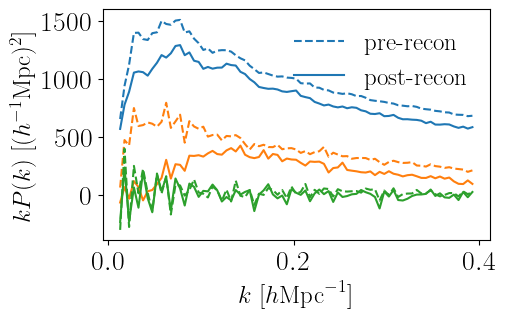

In [46]:
fig,ax = plt.subplots()
for ill, ell in enumerate(poles.ells):
    ax.plot(poles.k, poles.k*poles(ell=ell, complex=False), color='C{:d}'.format(ill), linestyle='--', label='pre-recon' if ill == 0 else None)
    ax.plot(poles_recon.k, poles_recon.k*poles_recon(ell=ell, complex=False), color='C{:d}'.format(ill), linestyle='-', label='post-recon' if ill == 0 else None)
ax.legend(frameon=False,fontsize=18)
ax.grid(False)
ax.set_xlabel(r'$k$ [$h\mathrm{Mpc}^{-1}$]',fontsize=18)
ax.set_ylabel(r'$k P(k)$ [$(h^{-1}\mathrm{Mpc})^{2}$]',fontsize=18)
fig.savefig('pre-_vs_post-recon_pk_multigrid.pdf')
plt.show()

pre_recon_pkfile='pre-recon_pk_multigrid.txt'
pre_recon_pkdata = np.vstack((poles.k, poles(ell=0,complex=False), poles(ell=2,complex=False), poles(ell=4,complex=False))).T
np.savetxt(pre_recon_pkfile,pre_recon_pkdata)
post_recon_pkfile='post-recon_pk_multigrid.txt'
post_recon_pkdata = np.vstack((poles_recon.k, poles_recon(ell=0,complex=False), poles_recon(ell=2,complex=False), poles_recon(ell=4,complex=False))).T
np.savetxt(post_recon_pkfile,post_recon_pkdata)

## Compute correlator to assess reconstruction

In [47]:
mesh_recon = CatalogMesh(data['Position_rec'], shifted_positions=randoms['Position_rec'],
                         boxsize=boxsize, boxcenter=boxcenter, nmesh=nmesh, resampler='tsc',
                         interlacing=3, position_type='pos')

muedges = np.linspace(-1., 1., 5)
# WARNING: input meshes (if not CatalogMesh) should be normalized as 1 + delta or nbar*(1 + delta);
# this is e.g. the case of "mesh_real" in this example
correlator = MeshFFTCorrelator(mesh_recon, mesh_real, edges=(kedges, muedges), los=los)

[001836.96] [0/1] 04-16 14:59  MeshFFTPower              INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[500 500 500], boxsize=[2000. 2000. 2000.], boxcenter=[0. 0. 0.], dtype=float64).
[001837.42] [0/1] 04-16 14:59  CatalogMesh               INFO     Slab 0 ~ 4194304 / 2802558.
[001838.75] [0/1] 04-16 14:59  CatalogMesh               INFO     Painted 2802558 out of 2802558 objects to mesh.
[001838.82] [0/1] 04-16 14:59  CatalogMesh               INFO     Slab 0 ~ 4194304 / 2800000.
[001840.55] [0/1] 04-16 14:59  CatalogMesh               INFO     Painted 2800000 out of 2800000 objects to mesh.
[001840.56] [0/1] 04-16 14:59  CatalogMesh               INFO     Running interlacing at order 3.
[001843.70] [0/1] 04-16 14:59  CatalogMesh               INFO     Slab 0 ~ 4194304 / 2802558.
[001845.10] [0/1] 04-16 14:59  CatalogMesh               INFO     Painted 2802558 out of 2802558 objects to mesh.
[001845.17] [0/1] 04-16 14:59  CatalogMesh               INFO     Slab 0 ~ 4194304 / 

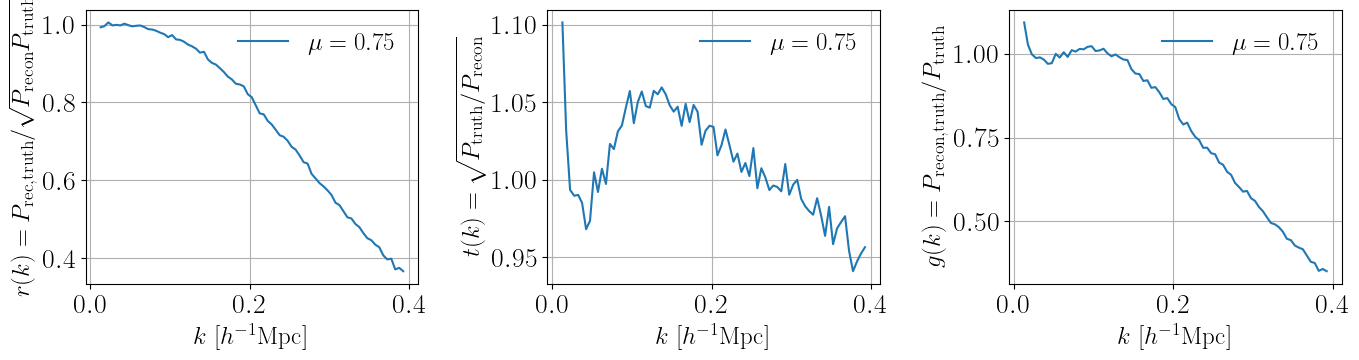

In [50]:
propagator = correlator.to_propagator(growth=bias)
transfer = correlator.to_transfer(growth=bias)
fig, lax = plt.subplots(nrows=1, ncols=3, figsize=(14,4))
fig.subplots_adjust(wspace=0.3)
lax = lax.flatten()
for imu, mu in enumerate(correlator.muavg[3:]):
    lax[0].plot(*correlator(mu=mu, return_k=True), label=r'$\mu = {:.2f}$'.format(mu))
    lax[1].plot(*transfer(mu=mu, return_k=True), label=r'$\mu = {:.2f}$'.format(mu))
    lax[2].plot(*propagator(mu=mu, return_k=True), label=r'$\mu = {:.2f}$'.format(mu))
for ax in lax:
    ax.legend(frameon=False,fontsize=18)
    ax.grid(True)
    ax.set_xlabel(r'$k$ [$h^{-1}\mathrm{Mpc}$]',fontsize=18)
lax[0].set_ylabel(r'$r(k) = P_{\mathrm{rec},\mathrm{truth}}/\sqrt{P_{\mathrm{recon}}P_{\mathrm{truth}}}$',fontsize=18)
lax[1].set_ylabel(r'$t(k) = \sqrt{P_{\mathrm{truth}}/P_{\mathrm{recon}}}$',fontsize=18)
lax[2].set_ylabel(r'$g(k) = P_{\mathrm{recon},\mathrm{truth}}/P_{\mathrm{truth}}$',fontsize=18)
fig.savefig('metrics_to_evaluate_reconstruction_quality_multigrid.pdf')
plt.tight_layout()
plt.show()

In [51]:
correlation_rk_file='metric_rk_multigrid.txt'
np.savetxt(correlation_rk_file,np.c_[correlator(mu=correlator.muavg[3:], return_k=True)])
transfer_tk_file='metric_tk_multigrid.txt'
np.savetxt(transfer_tk_file,np.c_[transfer(mu=correlator.muavg[3:], return_k=True)])
propagator_gk_file='metric_gk_multigrid.txt'
np.savetxt(propagator_gk_file,np.c_[propagator(mu=correlator.muavg[3:], return_k=True)])